# Import

In [26]:
import re
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from pyitlib import discrete_random_variable as drv
from sklearn.linear_model import LinearRegression

%matplotlib inline

print("Libraries imported successfully.")


Libraries imported successfully.


# Prepare the dataset

In [ ]:
recipes = pd.read_csv("RAW_recipes.csv")
print("Head of the dataset:")
print(recipes.head(), "\n")

# Filtering only the columns I am interested in
recipes_filtered = recipes[['name', 'tags', 'minutes', 'n_ingredients', 'steps', 'ingredients']].copy()

# Droping rows with missing values in steps or ingredients
recipes_filtered.dropna(subset=['steps', 'ingredients'], inplace=True)

# Converting steps from string to list, keeping only non-empty lists
def not_empty_steps(steps_str):
    try:
        steps_list = eval(steps_str)
        return len(steps_list) > 0
    except:
        return False

recipes_filtered = recipes_filtered[recipes_filtered['steps'].apply(not_empty_steps)]


Head of the dataset:
                                         name      id  minutes  \
0  arriba   baked winter squash mexican style  137739       55   
1            a bit different  breakfast pizza   31490       30   
2                   all in the kitchen  chili  112140      130   
3                          alouette  potatoes   59389       45   
4          amish  tomato ketchup  for canning   44061      190   

   contributor_id   submitted  \
0           47892  2005-09-16   
1           26278  2002-06-17   
2          196586  2005-02-25   
3           68585  2003-04-14   
4           41706  2002-10-25   

                                                tags  \
0  ['60-minutes-or-less', 'time-to-make', 'course...   
1  ['30-minutes-or-less', 'time-to-make', 'course...   
2  ['time-to-make', 'course', 'preparation', 'mai...   
3  ['60-minutes-or-less', 'time-to-make', 'course...   
4  ['weeknight', 'time-to-make', 'course', 'main-...   

                                    nutrition 

In [28]:
print("Dataset info:")
print(recipes.info())

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231637 entries, 0 to 231636
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   name            231636 non-null  object
 1   id              231637 non-null  int64 
 2   minutes         231637 non-null  int64 
 3   contributor_id  231637 non-null  int64 
 4   submitted       231637 non-null  object
 5   tags            231637 non-null  object
 6   nutrition       231637 non-null  object
 7   n_steps         231637 non-null  int64 
 8   steps           231637 non-null  object
 9   description     226658 non-null  object
 10  ingredients     231637 non-null  object
 11  n_ingredients   231637 non-null  int64 
dtypes: int64(5), object(7)
memory usage: 21.2+ MB
None


# Tokenization

In [ ]:
# Tokenize the steps
def preprocess_and_tokenize(steps_str):
    steps_list = eval(steps_str)  # Convert string to list
    text = " ".join(steps_list).lower()
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)      # Remove digits
    words = text.split()
    return words

recipes_filtered['tokenized_steps'] = recipes_filtered['steps'].apply(preprocess_and_tokenize)
print("Tokenization complete. Sample tokenized steps:")
print(recipes_filtered['tokenized_steps'].head())


Tokenization complete. Sample tokenized steps:
0    [make, a, choice, and, proceed, with, recipe, ...
1    [preheat, oven, to, degrees, f, press, dough, ...
2    [brown, ground, beef, in, large, pot, add, cho...
3    [place, potatoes, in, a, large, pot, of, light...
4    [mix, all, ingredients, boil, for, hours, or, ...
Name: tokenized_steps, dtype: object


# Grouping the recipes

In [ ]:
cuisines = [
    'italian', 'mexican', 'indian', 'chinese', 'french',
    'japanese', 'american', 'greek', 'thai', 'polish', 'english'
]

def extract_cuisine(tags_str):
    try:
        tags_list = eval(tags_str)
    except:
        return 'other'
    for c in cuisines:
        if c in tags_list:
            return c
    return 'other'

recipes_filtered['cuisine'] = recipes_filtered['tags'].apply(extract_cuisine)

def find_diet_tags(tags_str):
    try:
        tags_list = eval(tags_str)
    except:
        return 'other'
    if 'meat' in tags_list:
        return 'meat'
    elif 'vegetarian' in tags_list:
        return 'vegetarian'
    elif 'vegan' in tags_list:
        return 'vegan'
    return 'other'

recipes_filtered['diet_tags'] = recipes_filtered['tags'].apply(find_diet_tags)

# Defining the groups for my analyses (after the feedback natural categories only)
groups = ['cuisine', 'diet_tags']

for group in groups:
    print(f"Unique elements in {group}:")
    print(recipes_filtered[group].value_counts(), "\n")

Unique elements in cuisine:
other       175708
american     29010
italian       7410
mexican       6677
indian        2706
greek         2213
french        2201
chinese       1995
english       1416
thai          1156
japanese       795
polish         349
Name: cuisine, dtype: int64 

Unique elements in diet_tags:
other         139960
meat           56042
vegetarian     35634
Name: diet_tags, dtype: int64 



# Basic entropy measures

In [33]:
# Shannon Entropy (unigrams)
def calculate_entropy(words):
    word_counts = Counter(words)
    total_words = len(words)
    if total_words == 0:
        return 0.0
    probabilities = [count / total_words for count in word_counts.values()]
    entropy = -sum(p * np.log2(p) for p in probabilities)
    return entropy

recipes_filtered['entropy'] = recipes_filtered['tokenized_steps'].apply(calculate_entropy)
print("Basic entropy stats on the whole dataset:")
print(recipes_filtered['entropy'].describe())

# Conditional Entropy (bigrams)
def calculate_conditional_entropy(words):
    bigrams = [(words[i], words[i+1]) for i in range(len(words) - 1)]
    if len(bigrams) == 0:
        return 0.0
    bigram_counts = Counter(bigrams)
    unigram_counts = Counter(words)
    conditional_entropy_value = 0.0
    total_bigrams = sum(bigram_counts.values())
    for (w1, w2), count in bigram_counts.items():
        p_w1w2 = count / total_bigrams
        p_w1 = unigram_counts[w1] / len(words)
        if p_w1 > 0:
            p_cond = p_w1w2 / p_w1
            if p_cond > 0:
                conditional_entropy_value += p_w1w2 * np.log2(p_cond)
    conditional_entropy_value = -conditional_entropy_value
    return conditional_entropy_value

recipes_filtered['conditional_entropy'] = recipes_filtered['tokenized_steps'].apply(calculate_conditional_entropy)
print("\n\nBasic conditional entropy stats on the whole dataset:")
print(recipes_filtered['conditional_entropy'].describe())


Basic entropy stats on the whole dataset:
count    231636.000000
mean          5.451791
std           0.704029
min          -0.000000
25%           5.092987
50%           5.539623
75%           5.918865
max           7.999994
Name: entropy, dtype: float64


Basic conditional entropy stats on the whole dataset:
count    231636.000000
mean          0.612983
std           0.346685
min          -1.000000
25%           0.379619
50%           0.603108
75%           0.839824
max           2.567500
Name: conditional_entropy, dtype: float64


# N-gram entropy analysis

In [34]:
def calculate_ngram_entropy(words, n):
    if len(words) < n:
        return 0.0
    ngrams = [tuple(words[i:i+n]) for i in range(len(words) - n + 1)]
    ngram_counts = Counter(ngrams)
    total_ngrams = len(ngrams)
    entropy = 0.0
    for count in ngram_counts.values():
        p = count / total_ngrams
        entropy -= p * np.log2(p)
    return entropy

def run_analyses_solo(df, col_name):
    # Shannon Entropy
    avg_entropy = df.groupby(col_name)['entropy'].mean().sort_values()
    print(f"\nAverage Entropy by {col_name.title()}")
    print(avg_entropy)
    plt.figure(figsize=(8, 4))
    plt.bar(avg_entropy.index, avg_entropy.values, color='skyblue')
    plt.title(f'Average Entropy by {col_name.title()}')
    plt.xlabel(col_name.title())
    plt.ylabel('Entropy')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"./plots/shannon_entropy_by_{col_name}.png")
    plt.show()
    
    # Conditional Entropy
    avg_cond_entropy = df.groupby(col_name)['conditional_entropy'].mean().sort_values()
    print(f"\nAverage Conditional Entropy by {col_name.title()}")
    print(avg_cond_entropy)
    plt.figure(figsize=(8, 4))
    plt.bar(avg_cond_entropy.index, avg_cond_entropy.values, color='orange')
    plt.title(f'Average Conditional Entropy by {col_name.title()}')
    plt.xlabel(col_name.title())
    plt.ylabel('Conditional Entropy')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"./plots/conditional_entropy_by_{col_name}.png")
    plt.show()
    
    # N-gram Entropy Rates
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
    for i, n in enumerate([3, 4, 5]):
        col = f"{n}gram_entropy_rate"
        df[col] = df['tokenized_steps'].apply(lambda words: calculate_ngram_entropy(words, n=n) / n)
        avg_ngram = df.groupby(col_name)[col].mean().sort_values()
        axs[i].bar(avg_ngram.index, avg_ngram.values, color='green')
        axs[i].set_title(f'Average {n}gram Entropy Rate by {col_name.title()}')
        axs[i].set_xlabel(col_name.title())
        axs[i].set_ylabel(f'{n}gram Entropy Rate')
        axs[i].tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.savefig(f"./plots/ngram_entropy_rates_by_{col_name}.png")
    plt.show()


# Mutual information among categories

In [ ]:
def mutual_info(df, col1, col2):
    temp_df = df[[col1, col2]].dropna().copy()
    temp_df[col1] = temp_df[col1].astype(str)
    temp_df[col2] = temp_df[col2].astype(str)
    temp_df[col1] = temp_df[col1].astype('category')
    temp_df[col2] = temp_df[col2].astype('category')
    x_cat = temp_df[col1].cat.codes.astype(int).values
    y_cat = temp_df[col2].cat.codes.astype(int).values
    neg_mask = (x_cat < 0) | (y_cat < 0)
    if neg_mask.any():
        print(f"[DEBUG] Dropping {neg_mask.sum()} rows with negative codes in {col1} or {col2}.")
        x_cat = x_cat[~neg_mask]
        y_cat = y_cat[~neg_mask]
    if len(x_cat) == 0:
        print(f"[WARNING] No valid rows remain for {col1} vs {col2} — returning 0.")
        return 0.0
    return drv.information_mutual(
        X=x_cat, Y=y_cat,
        cartesian_product=False,
        Alphabet_X=None,
        Alphabet_Y=None,
        estimator='ML',
        base=2
    )
    
for i in range(len(groups)):
    for j in range(i+1, len(groups)):
        mi_value = mutual_info(recipes_filtered, groups[i], groups[j])
        print(f"Mutual Information between {groups[i]} and {groups[j]}: {mi_value:.4f}")


Mutual Information between cuisine and diet_tags: 0.0205


# Regression analysis - linear vs logistic regression for predicting the entropy


Linear Regression for 'n_ingredients':
   Coefficient: 0.0780
   Intercept:   4.7457
   R²:          0.1712

Logarithmic Regression for 'n_ingredients' (using log transformation):
   Coefficient: 0.6750
   Intercept:   4.0254
   R²:          0.1777

Linear Regression for 'recipe_length':
   Coefficient: 0.0074
   Intercept:   4.6930
   R²:          0.6096

Logarithmic Regression for 'recipe_length' (using log transformation):
   Coefficient: 0.9420
   Intercept:   1.3135
   R²:          0.9207

Linear Regression for 'n_steps_count':
   Coefficient: 0.0887
   Intercept:   4.5854
   R²:          0.5707

Logarithmic Regression for 'n_steps_count' (using log transformation):
   Coefficient: 0.9897
   Intercept:   3.3719
   R²:          0.7625


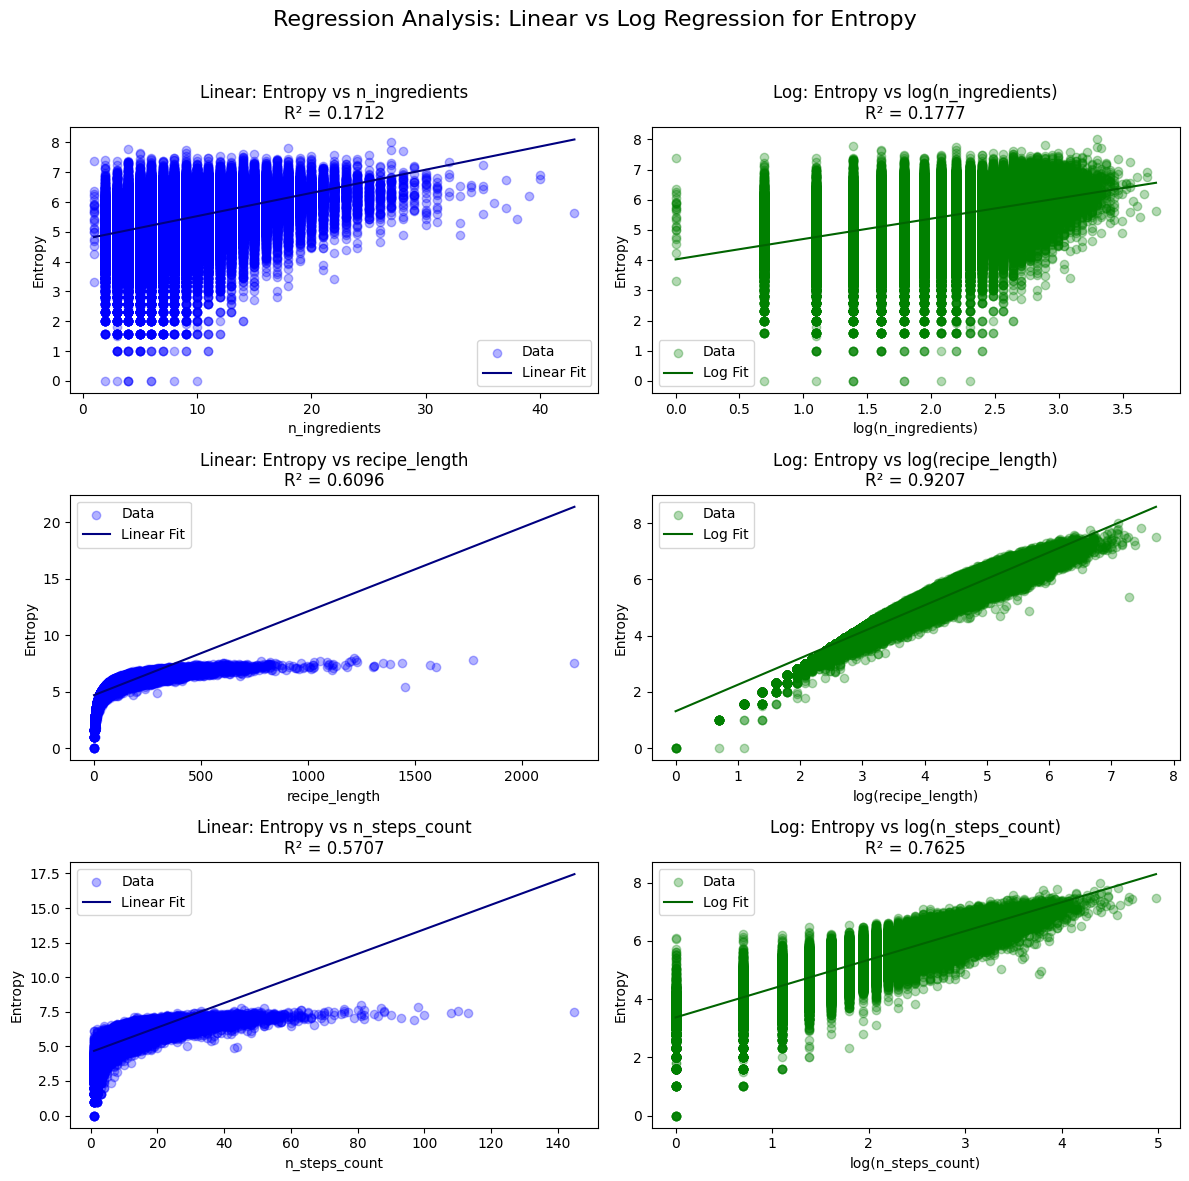

In [36]:
def calculate_recipe_length(steps_str):
    # Converting the string representation of the list into an actual list and count total words
    steps_list = eval(steps_str)
    total_words = sum(len(step.split()) for step in steps_list)
    return total_words

def count_steps(steps_str):
    # Converting the string representation of the list into an actual list and count the steps
    steps_list = eval(steps_str)
    return len(steps_list)

if 'recipe_length' not in recipes_filtered.columns:
    recipes_filtered['recipe_length'] = recipes_filtered['steps'].apply(calculate_recipe_length)
if 'n_steps_count' not in recipes_filtered.columns:
    recipes_filtered['n_steps_count'] = recipes_filtered['steps'].apply(count_steps)

predictors = ['n_ingredients', 'recipe_length', 'n_steps_count']

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))
fig.suptitle("Regression Analysis: Linear vs Log Regression for Entropy", fontsize=16)

for i, predictor in enumerate(predictors):
    y = recipes_filtered['entropy'].values

    # -------- (Left Column) --------
    X_lin = recipes_filtered[[predictor]].values
    lin_model = LinearRegression()
    lin_model.fit(X_lin, y)
    y_pred_lin = lin_model.predict(X_lin)
    r2_lin = lin_model.score(X_lin, y)
    
    print(f"\nLinear Regression for '{predictor}':")
    print(f"   Coefficient: {lin_model.coef_[0]:.4f}")
    print(f"   Intercept:   {lin_model.intercept_:.4f}")
    print(f"   R²:          {r2_lin:.4f}")
    
    ax_lin = axs[i, 0]
    ax_lin.scatter(X_lin, y, alpha=0.3, color="blue", label="Data")
    sorted_idx = X_lin[:, 0].argsort()
    ax_lin.plot(X_lin[sorted_idx], y_pred_lin[sorted_idx], color="navy", label="Linear Fit")
    ax_lin.set_xlabel(predictor)
    ax_lin.set_ylabel("Entropy")
    ax_lin.set_title(f"Linear: Entropy vs {predictor}\nR² = {r2_lin:.4f}")
    ax_lin.legend()
    
    # -------- (Right Column) --------
    X_log = np.log(recipes_filtered[[predictor]].values)
    log_model = LinearRegression()
    log_model.fit(X_log, y)
    y_pred_log = log_model.predict(X_log)
    r2_log = log_model.score(X_log, y)
    
    print(f"\nLogarithmic Regression for '{predictor}' (using log transformation):")
    print(f"   Coefficient: {log_model.coef_[0]:.4f}")
    print(f"   Intercept:   {log_model.intercept_:.4f}")
    print(f"   R²:          {r2_log:.4f}")
    
    ax_log = axs[i, 1]
    ax_log.scatter(X_log, y, alpha=0.3, color="green", label="Data")
    sorted_idx = X_log[:, 0].argsort()
    ax_log.plot(X_log[sorted_idx], y_pred_log[sorted_idx], color="darkgreen", label="Log Fit")
    ax_log.set_xlabel(f"log({predictor})")
    ax_log.set_ylabel("Entropy")
    ax_log.set_title(f"Log: Entropy vs log({predictor})\nR² = {r2_log:.4f}")
    ax_log.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("./plots/regression_analysis_grid.png")
plt.show()


# Zipf's Law analysis

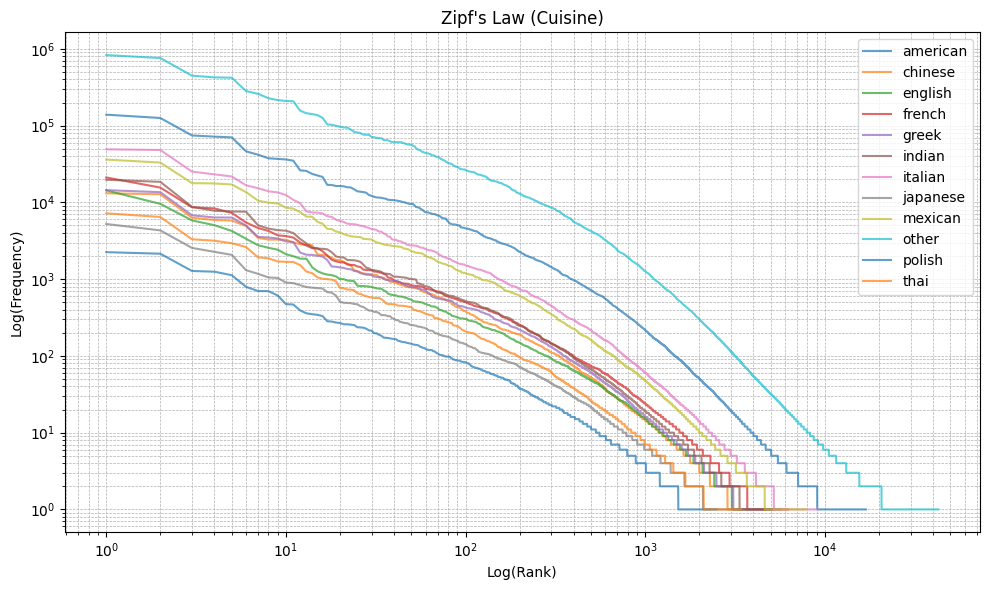


Zipf's Law Fit Results (alpha, R^2) by Cuisine


C:\Users\Kvmilos\AppData\Local\Temp\ipykernel_4848\1885579214.py:15: RuntimeWarning: overflow encountered in power
  return C * rank ** (-alpha)
C:\Users\Kvmilos\AppData\Local\Temp\ipykernel_4848\1885579214.py:15: RuntimeWarning: overflow encountered in multiply
  return C * rank ** (-alpha)


american             -> alpha = 0.78, R^2 = 0.95
chinese              -> alpha = 0.79, R^2 = 0.94
english              -> alpha = 0.87, R^2 = 0.99
french               -> alpha = 0.84, R^2 = 0.98
greek                -> alpha = 0.80, R^2 = 0.95
indian               -> alpha = 0.82, R^2 = 0.95
italian              -> alpha = 0.79, R^2 = 0.95
japanese             -> alpha = 0.81, R^2 = 0.97
mexican              -> alpha = 0.78, R^2 = 0.95
other                -> alpha = 0.79, R^2 = 0.95
polish               -> alpha = 0.77, R^2 = 0.95
thai                 -> alpha = 0.79, R^2 = 0.96


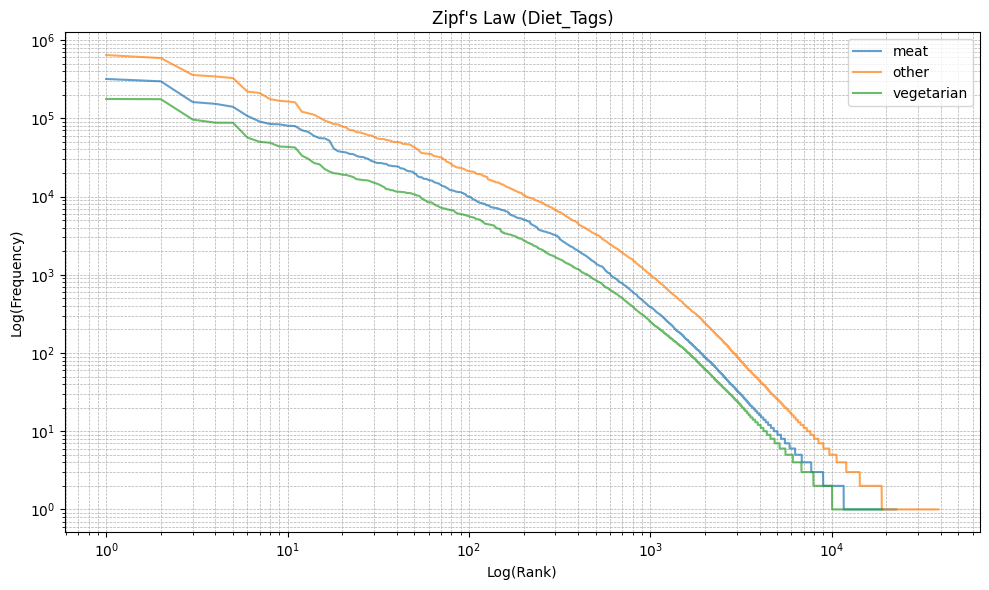


Zipf's Law Fit Results (alpha, R^2) by Diet_Tags


C:\Users\Kvmilos\AppData\Local\Temp\ipykernel_4848\1885579214.py:15: RuntimeWarning: overflow encountered in power
  return C * rank ** (-alpha)
C:\Users\Kvmilos\AppData\Local\Temp\ipykernel_4848\1885579214.py:15: RuntimeWarning: overflow encountered in multiply
  return C * rank ** (-alpha)


meat                 -> alpha = 0.79, R^2 = 0.95
other                -> alpha = 0.79, R^2 = 0.95
vegetarian           -> alpha = 0.80, R^2 = 0.94


In [37]:
def calculate_word_frequencies(tokenized_col):
    all_words = []
    for tokens in tokenized_col:
        all_words.extend(tokens)
    word_counts = Counter(all_words)
    ranked_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
    ranks = np.arange(1, len(ranked_words) + 1)
    frequencies = np.array([freq for _, freq in ranked_words])
    return ranks, frequencies

def power_law(rank, alpha, C):
    return C * rank ** (-alpha)

def fit_power_law(ranks, frequencies):
    params, _ = curve_fit(power_law, ranks, frequencies, maxfev=10000)
    alpha, C = params
    predicted = power_law(ranks, alpha, C)
    ss_res = np.sum((frequencies - predicted) ** 2)
    ss_tot = np.sum((frequencies - np.mean(frequencies)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    return alpha, C, r_squared

def zipf_analysis(df, group_col):
    grouped = df.groupby(group_col)
    plt.figure(figsize=(10, 6))
    for label, group_df in grouped:
        ranks, frequencies = calculate_word_frequencies(group_df['tokenized_steps'])
        if len(ranks) > 0:
            plt.loglog(ranks, frequencies, label=label, alpha=0.7)
    plt.title(f"Zipf's Law ({group_col.title()})")
    plt.xlabel("Log(Rank)")
    plt.ylabel("Log(Frequency)")
    plt.legend()
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.savefig(f"./plots/zipf_law_{group_col}.png")
    plt.show()
    
    print(f"\nZipf's Law Fit Results (alpha, R^2) by {group_col.title()}")
    for label, group_df in grouped:
        ranks, frequencies = calculate_word_frequencies(group_df['tokenized_steps'])
        if len(ranks) > 5:
            alpha, C, r2 = fit_power_law(ranks, frequencies)
            print(f"{label:20s} -> alpha = {alpha:.2f}, R^2 = {r2:.2f}")
        else:
            print(f"{label:20s} -> Not enough words to fit a power law.")

for col in groups:
    zipf_analysis(recipes_filtered, col)


# Running the analysis


Average Entropy by Cuisine
cuisine
other       5.425782
japanese    5.453230
american    5.460493
mexican     5.530682
thai        5.569855
greek       5.571577
indian      5.582138
chinese     5.607801
polish      5.668986
italian     5.677138
english     5.707811
french      5.731660
Name: entropy, dtype: float64


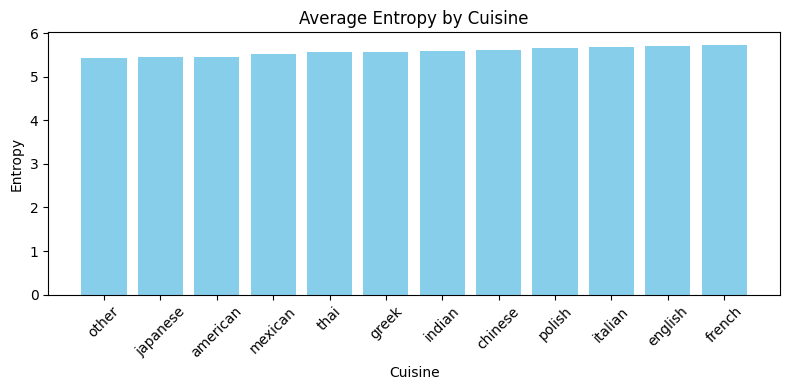


Average Conditional Entropy by Cuisine
cuisine
other       0.596255
american    0.602172
mexican     0.642093
japanese    0.676789
thai        0.708442
greek       0.710462
polish      0.726241
italian     0.764622
indian      0.766890
chinese     0.773229
english     0.826957
french      0.830789
Name: conditional_entropy, dtype: float64


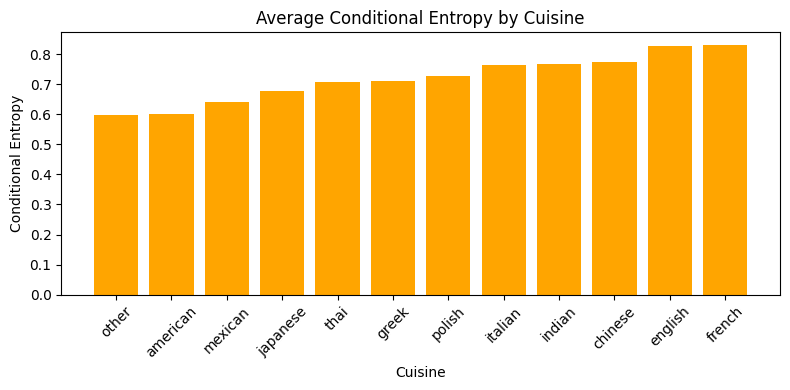

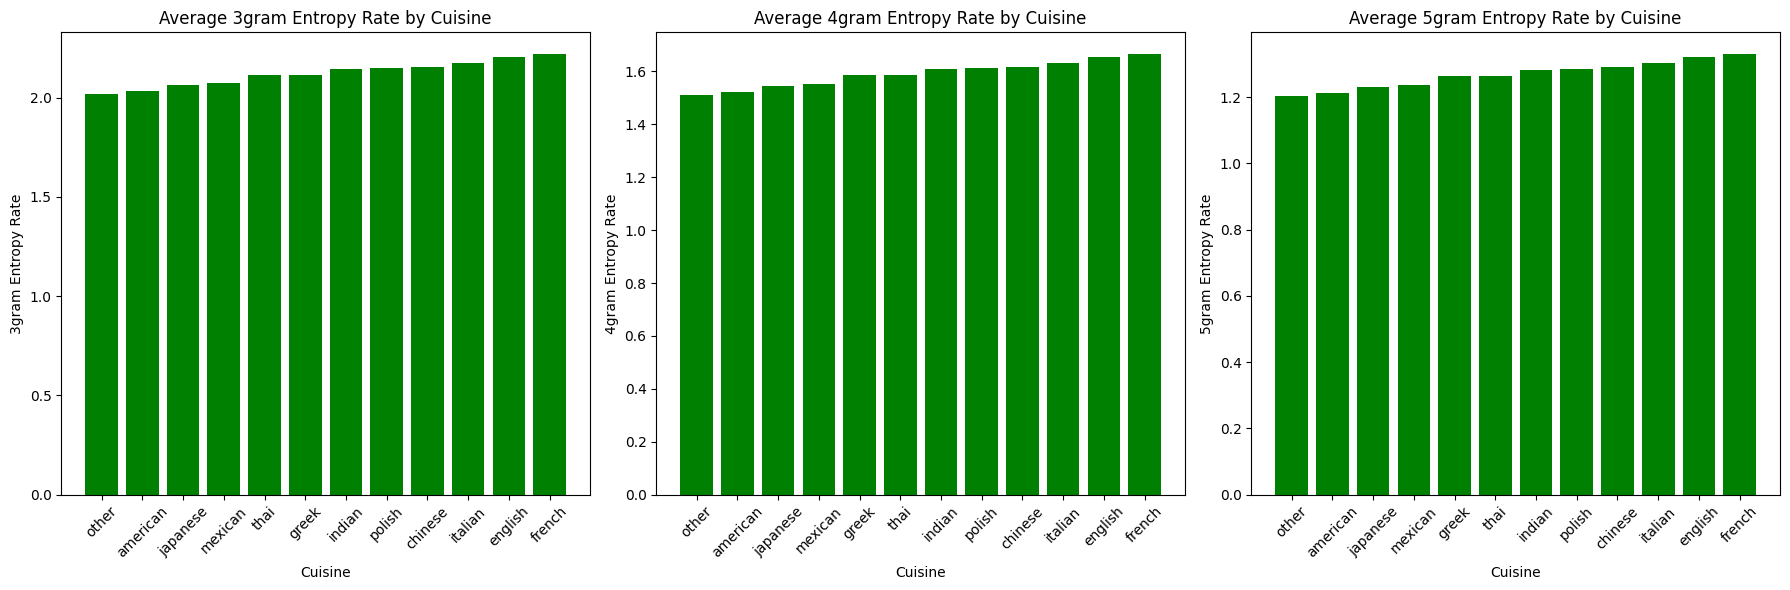


Average Entropy by Diet_Tags
diet_tags
vegetarian    5.408750
other         5.409168
meat          5.585606
Name: entropy, dtype: float64


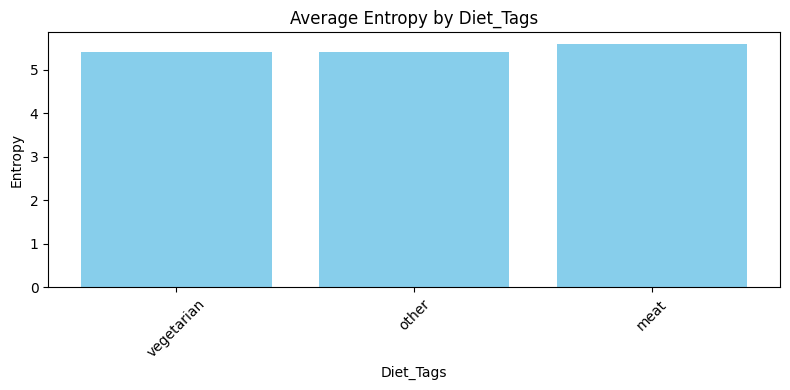


Average Conditional Entropy by Diet_Tags
diet_tags
other         0.582526
vegetarian    0.610124
meat          0.690863
Name: conditional_entropy, dtype: float64


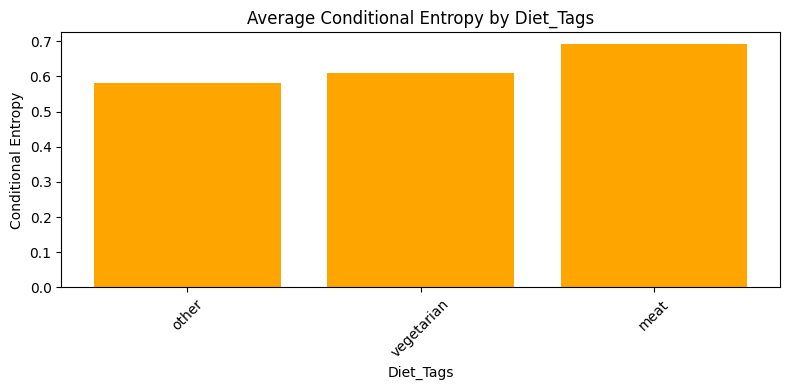

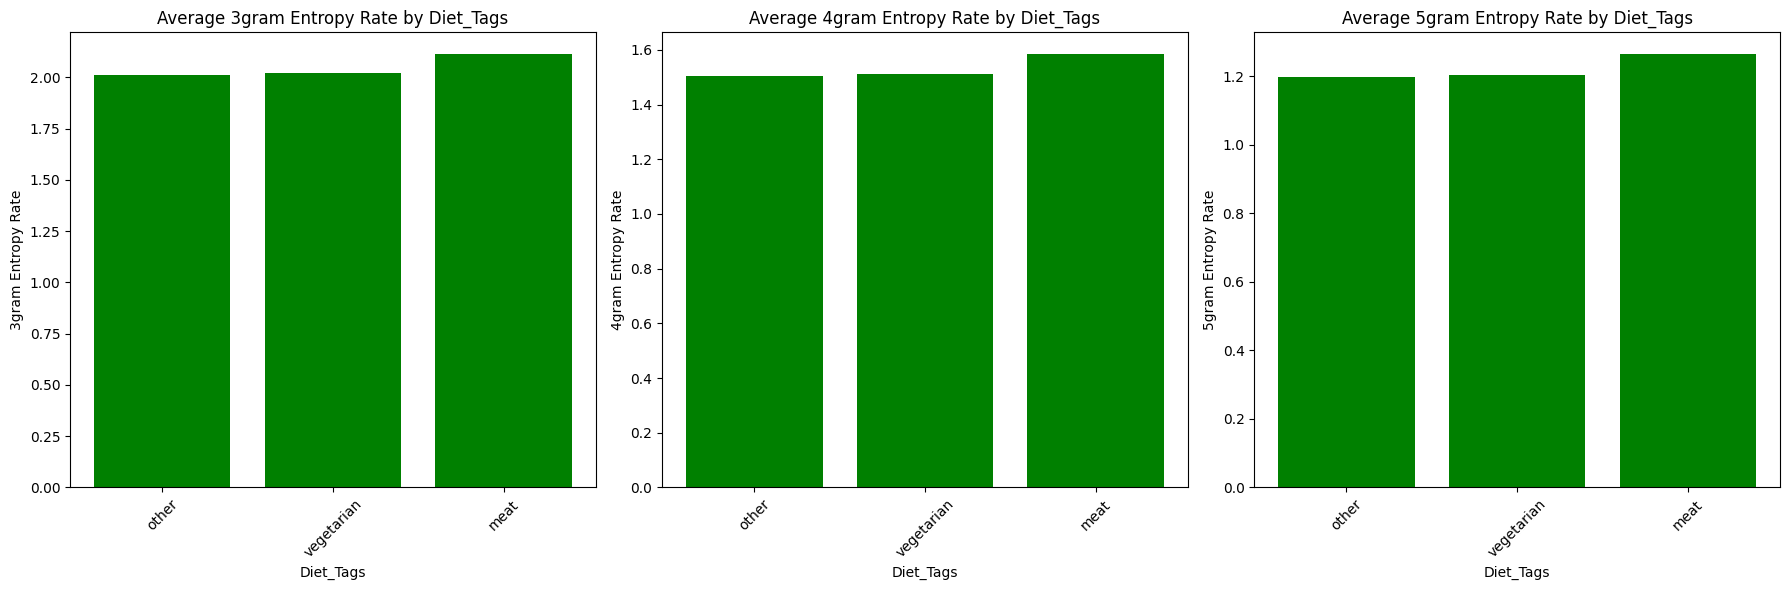

In [ ]:
for col in groups:
    run_analyses_solo(recipes_filtered, col)
